#GoingDeeper - CAM, Grad-CAM Project

- 구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. 라이브러리 가져오기

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

- GPU확인

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##2. 데이터 불러오기(stanford_dogs)

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

- train 데이터 확인

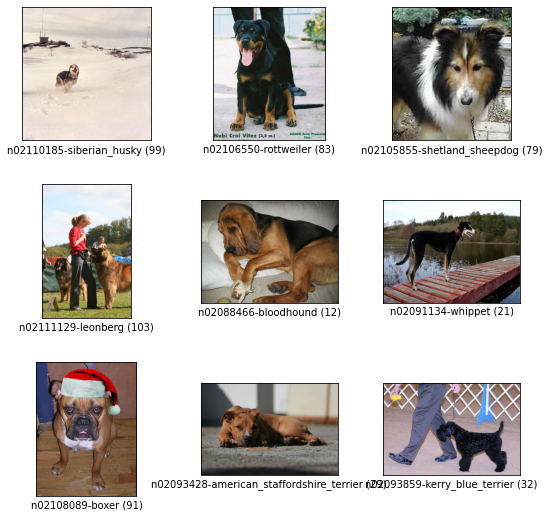

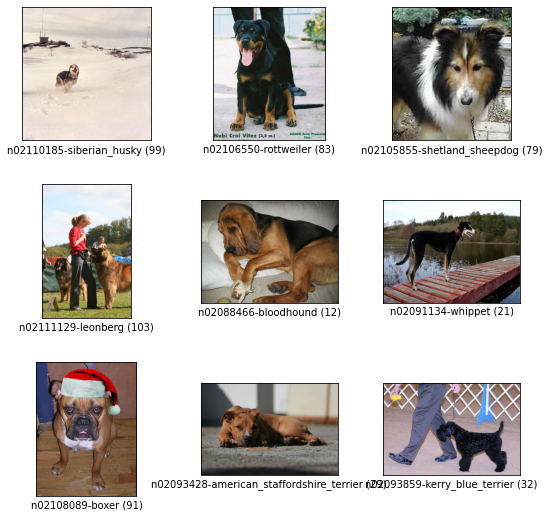

In [5]:
tfds.show_examples(ds_train, ds_info)

- test 데이터 확인

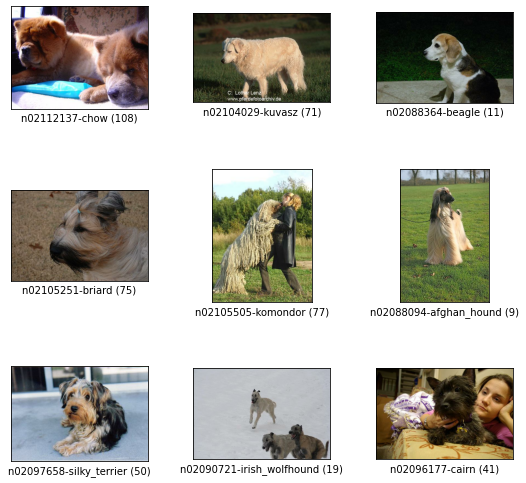

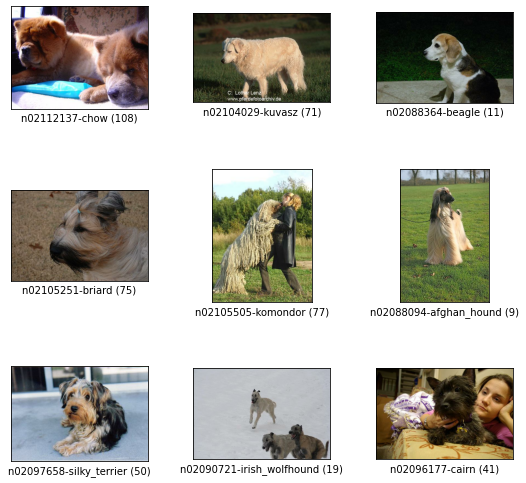

In [6]:
tfds.show_examples(ds_test, ds_info)

- features 구성 확인

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 3. 모델 생성(Resnet50)

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

##4. 모델 학습

- 이미지 정규화, resize 함수 / 적용 함수

In [10]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


- model compile

In [12]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


- model fit(EPOCH = 10)

In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 204ms/step - loss: 2.2201 - accuracy: 0.4427 - val_loss: 3.1030 - val_accuracy: 0.2444
Epoch 2/20
750/750 [==============================] - 156s 209ms/step - loss: 0.7033 - accuracy: 0.8068 - val_loss: 1.0700 - val_accuracy: 0.6894
Epoch 3/20
750/750 [==============================] - 158s 210ms/step - loss: 0.2062 - accuracy: 0.9590 - val_loss: 0.9364 - val_accuracy: 0.7247
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0530 - accuracy: 0.9962 - val_loss: 0.9383 - val_accuracy: 0.7306
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0222 - accuracy: 0.9993 - val_loss: 0.9085 - val_accuracy: 0.7390
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0131 - accuracy: 0.9999 - val_loss: 0.9274 - val_accuracy: 0.7347
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9392 -

- 학습시킨 가중치 저장

In [14]:
import os

cam_model_path = '/content/drive/MyDrive/GoingDeeper/GoingDeeper_5_6/cam_model2.h5'
cam_model.save(cam_model_path)

##5. CAM

- CAM 생성 작업은 데이터셋 배치 단위가 아닌 개별 이미지 데이터 단위로 이루어지기 때문에 get_one()함수로 데이터셋에서 한 장씩 뽑을 수 있도록 한다.

In [15]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


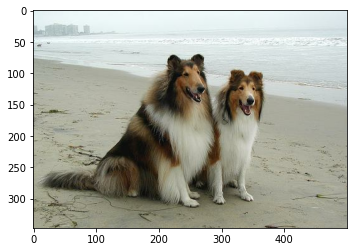

In [16]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 학습한 모델 불러오기

In [17]:
import os
cam_model_path = '/content/drive/MyDrive/GoingDeeper/GoingDeeper_5_6/cam_model2.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

- CAM을 생성하기 위해 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

- CAM 이미지

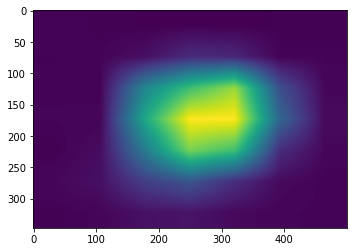

In [19]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

- CAM 이미지를 원본과 합치기

In [20]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

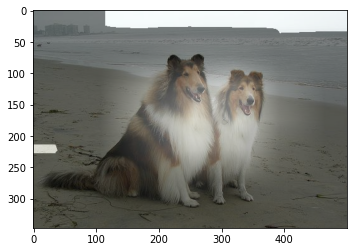

In [21]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- 강아지가 두 마리라 한마리만 인식을 하게되면 어떡하지라는 걱정을 했지만 두 마리 강아지의 얼굴 부분이 강조가 되었고 얼굴 주변으로까지 강조되는 것을 알 수 있었다.

## 6. Grad-CAM

- Grad-CAM을 이용해 CAM만들기

67


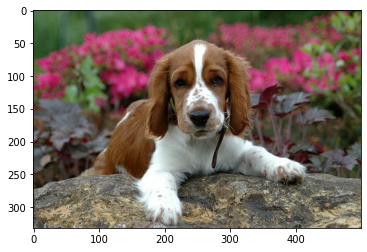

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.

- Grad-CAM 함수

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

- conv5

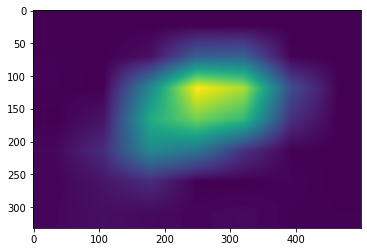

In [24]:
grad_cam_image_conv5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_conv5)
plt.show()

- Grad-CAM 원본이미지 합치기(conv5)

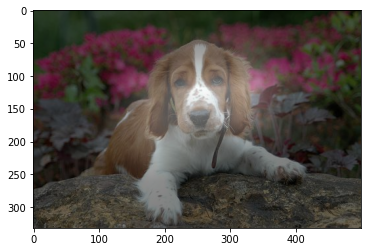

In [25]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image_conv5*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- conv4

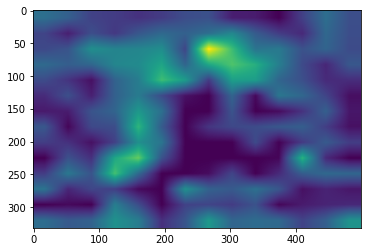

In [26]:
grad_cam_image_conv4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_conv4)
plt.show()

- Grad-CAM 원본이미지 합치기(conv4)

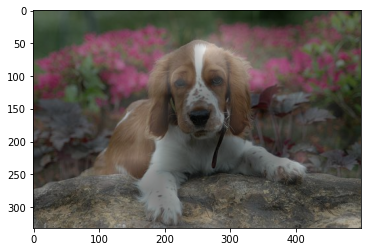

In [27]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image_conv4*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- conv3

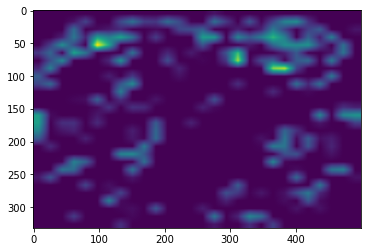

In [28]:
grad_cam_image_conv3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image_conv3)
plt.show()

- Grad-CAM 원본이미지 합치기(conv3)

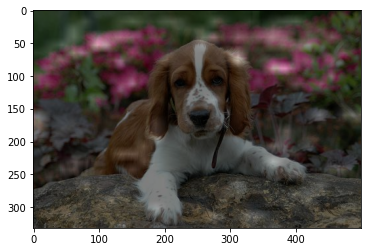

In [29]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image_conv3*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 7. Detection with CAM

### CAM

- 바운딩 박스

108


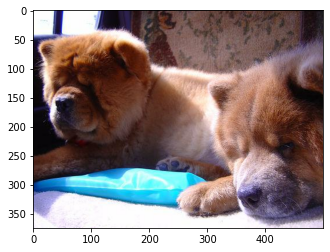

In [30]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- generate_cam()을 활용해서 CAM 이미지를 뽑았습니다. 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 int 자료형으로 변환해 줍니다.

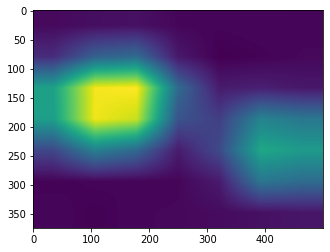

In [31]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [32]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [33]:
rect = get_bbox(cam_image)
rect

array([[495, 362],
       [-37, 271],
       [  8,   1],
       [542,  92]])

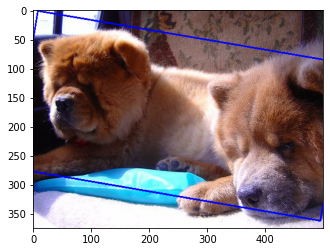

In [34]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### IoU는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [35]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

- rect를 minmax bbox형태로 치환

In [36]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0026666666666666666, -0.074, 0.9653333333333334, 1.084]

In [37]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

- IoU계산

In [38]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [39]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.38185523031918134

### Grad-CAM

108


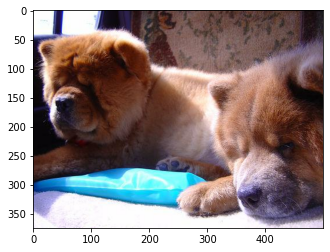

In [40]:
print(item['label'])
plt.imshow(item['image'])
plt.show()

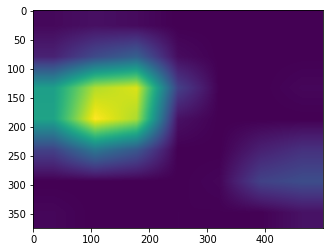

In [41]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [42]:
def get_grad_cam_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

- Grad-CAM 바운딩 박스

In [43]:
rect_grad_cam = get_grad_cam_bbox(grad_cam_image)
rect_grad_cam

array([[336, 346],
       [336, 206],
       [499, 206],
       [499, 346]])

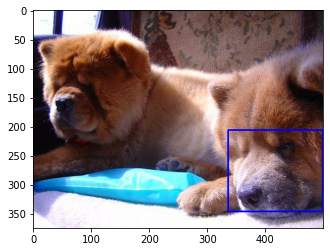

In [48]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_grad_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

- Grad-CAM IoU

In [49]:
pred_bbox_grad_cam = rect_to_minmax(rect_grad_cam, item['image'])
pred_bbox_grad_cam

[0.5493333333333333, 0.672, 0.9226666666666666, 0.998]

In [50]:
get_iou(pred_bbox_grad_cam, item['objects']['bbox'][0])

0.28591118186525893

- CAM_IoU : 0.38
- Grad-CAM_IoU : 0.29


## 8. 회고

- CAM과 Grad-CAM 경우 원본이미지를 합쳤을 때 인식되어야 하는 부분들이 잘나온 편인 것 같다.
- 바운딩 박스를 적용할 때에 CAM은 정상적으로 나왔지만, Grad-CAM같은 경우 오른쪽 강아지 코부분만 바운딩 박스가 적용되어 문제가 있는 것 같다.
- IoU는 바운딩 박스로 가늠이 되지만 수치상으로도 CAM이 Grad-CAM보다 높게 나온 것을 알 수 있었다.
- 각 모델의 함수 코드를 작성하는 것에 있어서 많은 어려움이 있어 노드의 코드를 많이 참고한 것 같다.
- Grad-CAM의 바운딩 박스에 대해 좀 더 공부할 필요가 있다고 본다.